# The code provides both time-series forecasts of future accident rates and severity levels, plus classification models to predict accident severity based on various features.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [3]:
df = pd.read_csv(r'C:\Users\elsay\Desktop\My-Github\Analytics-Alchemists\Road Accident Data.csv')
df.head()

,Accident_Index,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
0,200901BS70001,1/1/2021,Jan,Thursday,2021,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,...,1,2,Metropolitan Police,Dry,One way street,30,15:11,Urban,Fine no high winds,Car
1,200901BS70002,1/5/2021,Jan,Monday,2021,Give way or uncontrolled,Crossroads,Serious,51.514399,Daylight,...,11,2,Metropolitan Police,Wet or damp,Single carriageway,30,10:59,Urban,Fine no high winds,Taxi/Private hire car
2,200901BS70003,1/4/2021,Jan,Sunday,2021,Give way or uncontrolled,T or staggered junction,Slight,51.486668,Daylight,...,1,2,Metropolitan Police,Dry,Single carriageway,30,14:19,Urban,Fine no high winds,Taxi/Private hire car
3,200901BS70004,1/5/2021,Jan,Monday,2021,Auto traffic signal,T or staggered junction,Serious,51.507804,Daylight,...,1,2,Metropolitan Police,Frost or ice,Single carriageway,30,8:10,Urban,Other,Motorcycle over 500cc
4,200901BS70005,1/6/2021,Jan,Tuesday,2021,Auto traffic signal,Crossroads,Serious,51.482076,Darkness - lights lit,...,1,2,Metropolitan Police,Dry,Single carriageway,30,17:25,Urban,Fine no high winds,Car


In [4]:
df.tail()

,Accident_Index,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
307968,201091NM01760,2/18/2022,Feb,Thursday,2022,Data missing or out of range,Not at junction or within 20 metres,Slight,57.374005,Daylight,...,2,1,Northern,Dry,Single carriageway,60,7:00,Rural,Fine no high winds,Car
307969,201091NM01881,2/21/2022,Feb,Sunday,2022,Data missing or out of range,Not at junction or within 20 metres,Slight,57.232273,Darkness - no lighting,...,1,1,Northern,Frost or ice,Single carriageway,60,3:00,Rural,Fine no high winds,Car
307970,201091NM01935,2/23/2022,Feb,Tuesday,2022,Give way or uncontrolled,T or staggered junction,Slight,57.585044,Daylight,...,1,3,Northern,Frost or ice,Single carriageway,30,9:38,Rural,Fine no high winds,Car
307971,201091NM01964,2/23/2022,Feb,Tuesday,2022,Give way or uncontrolled,T or staggered junction,Serious,57.214898,Darkness - no lighting,...,1,2,Northern,Wet or damp,Single carriageway,60,18:25,Rural,Fine no high winds,Motorcycle over 500cc
307972,201091NM02142,2/28/2022,Feb,Sunday,2022,Give way or uncontrolled,T or staggered junction,Serious,57.575210,Daylight,...,1,1,Northern,Wet or damp,Dual carriageway,60,15:45,Rural,Snowing no high winds,Car


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307973 entries, 0 to 307972
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Accident_Index              307973 non-null  object 
 1   Accident Date               307973 non-null  object 
 2   Month                       307973 non-null  object 
 3   Day_of_Week                 307973 non-null  object 
 4   Year                        307973 non-null  int64  
 5   Junction_Control            307973 non-null  object 
 6   Junction_Detail             307973 non-null  object 
 7   Accident_Severity           307973 non-null  object 
 8   Latitude                    307973 non-null  float64
 9   Light_Conditions            307973 non-null  object 
 10  Local_Authority_(District)  307973 non-null  object 
 11  Carriageway_Hazards         5424 non-null    object 
 12  Longitude                   307973 non-null  float64
 13  Number_of_Casu

In [6]:
df.describe()

,Year,Latitude,Longitude,Number_of_Casualties,Number_of_Vehicles,Speed_limit
count,307973.000000,307973.000000,307973.000000,307973.000000,307973.000000,307973.000000
mean,2021.468934,52.487005,-1.368884,1.356882,1.829063,38.866037
std,0.499035,1.339011,1.356092,0.815857,0.710477,14.032933
min,2021.000000,49.914488,-7.516225,1.000000,1.000000,10.000000
25%,2021.000000,51.485248,-2.247937,1.000000,1.000000,30.000000
50%,2021.000000,52.225943,-1.349258,1.000000,2.000000,30.000000
75%,2022.000000,53.415517,-0.206810,1.000000,2.000000,50.000000
max,2022.000000,60.598055,1.759398,48.000000,32.000000,70.000000


In [7]:
df.columns

Index(['Accident_Index', 'Accident Date', 'Month', 'Day_of_Week', 'Year',
       'Junction_Control', 'Junction_Detail', 'Accident_Severity', 'Latitude',
       'Light_Conditions', 'Local_Authority_(District)', 'Carriageway_Hazards',
       'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles',
       'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit',
       'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type'],
      dtype='object')

In [8]:
df.shape

(307973, 23)

# EDA (Data Cleaning)


In [9]:
print("\nCleaning data...")
columns_to_drop = ['Accident_Index', 'Carriageway_Hazards']
df.drop(columns_to_drop, axis=1, inplace=True)


Cleaning data...


In [10]:
df.duplicated().sum()

5

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.isnull().sum().sort_index(ascending=False)

Year                             0
Weather_Conditions            6057
Vehicle_Type                     0
Urban_or_Rural_Area              0
Time                            17
Speed_limit                      0
Road_Type                     1534
Road_Surface_Conditions        317
Police_Force                     0
Number_of_Vehicles               0
Number_of_Casualties             0
Month                            0
Longitude                        0
Local_Authority_(District)       0
Light_Conditions                 0
Latitude                         0
Junction_Detail                  0
Junction_Control                 0
Day_of_Week                      0
Accident_Severity                0
Accident Date                    0
dtype: int64

# Replacing missing values with most frequent data

In [13]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
df['Road_Surface_Conditions'] = imputer.fit_transform(df[['Road_Surface_Conditions']]).ravel()
df['Weather_Conditions'] = imputer.fit_transform(df[['Weather_Conditions']]).ravel()
df['Time'] = imputer.fit_transform(df[['Time']]).ravel()
df['Road_Type'] = imputer.fit_transform(df[['Road_Type']]).ravel()


In [14]:
df.isnull().sum().sort_index(ascending=False)

Year                          0
Weather_Conditions            0
Vehicle_Type                  0
Urban_or_Rural_Area           0
Time                          0
Speed_limit                   0
Road_Type                     0
Road_Surface_Conditions       0
Police_Force                  0
Number_of_Vehicles            0
Number_of_Casualties          0
Month                         0
Longitude                     0
Local_Authority_(District)    0
Light_Conditions              0
Latitude                      0
Junction_Detail               0
Junction_Control              0
Day_of_Week                   0
Accident_Severity             0
Accident Date                 0
dtype: int64

In [15]:
df.columns

Index(['Accident Date', 'Month', 'Day_of_Week', 'Year', 'Junction_Control',
       'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Longitude', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Speed_limit', 'Time', 'Urban_or_Rural_Area',
       'Weather_Conditions', 'Vehicle_Type'],
      dtype='object')

# Data Visualisation

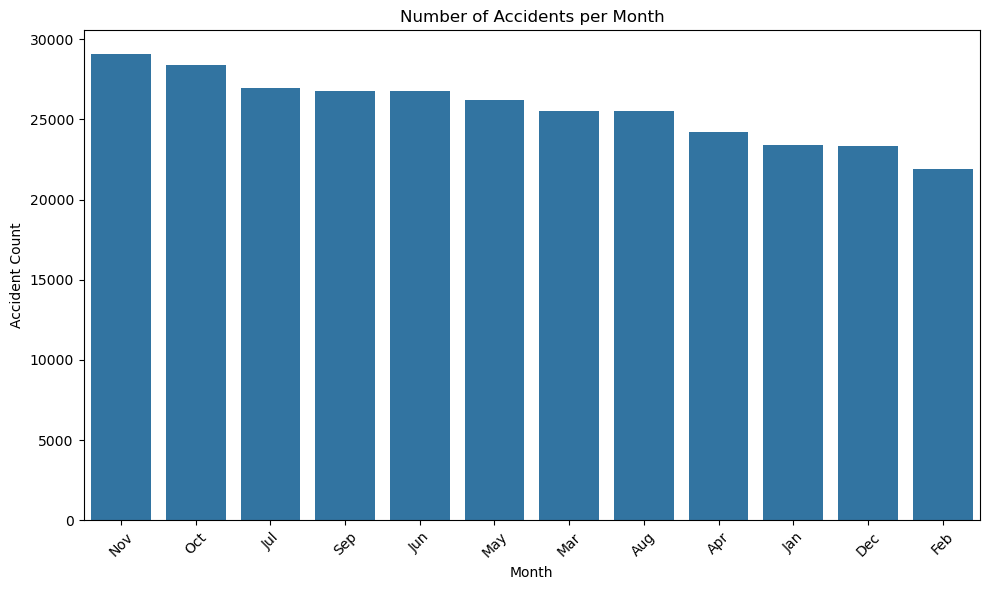

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Month', order=df['Month'].value_counts().index)
plt.title('Number of Accidents per Month')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


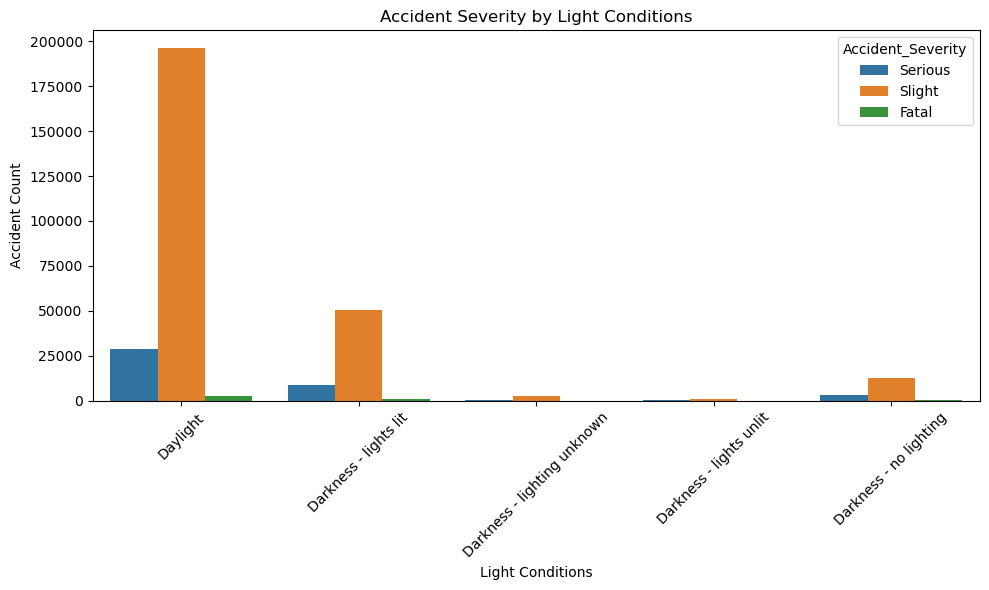

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Light_Conditions', hue='Accident_Severity')
plt.title('Accident Severity by Light Conditions')
plt.xlabel('Light Conditions')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


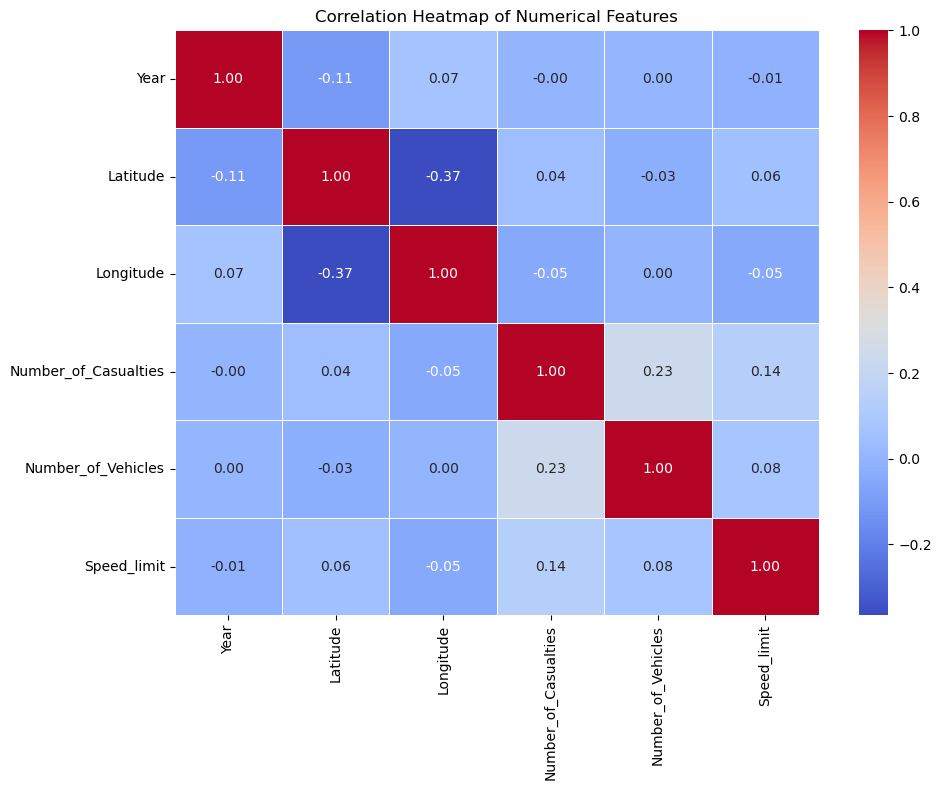

In [18]:

numeric_cols = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


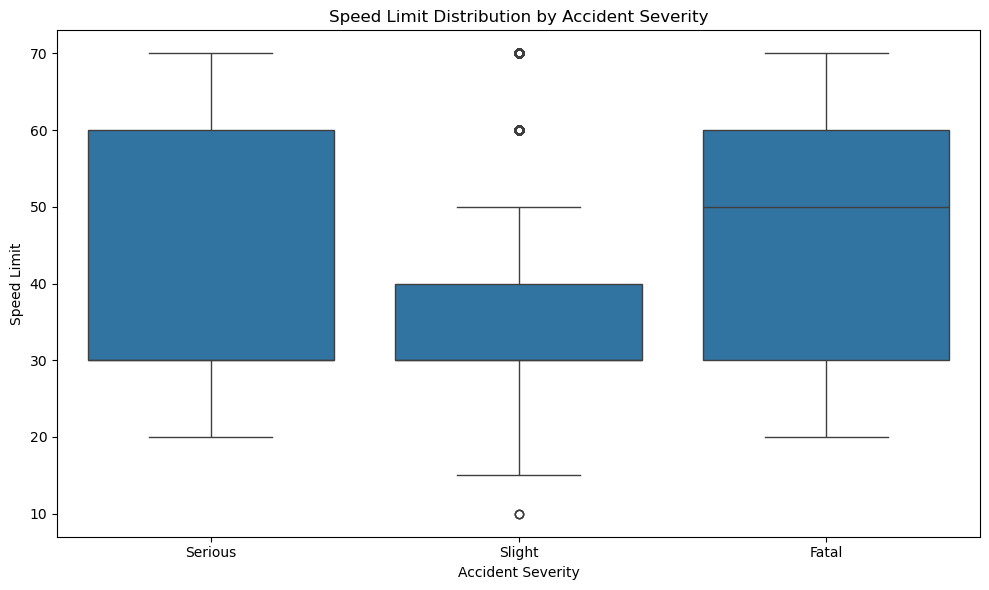

In [19]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Accident_Severity', y='Speed_limit')
plt.title('Speed Limit Distribution by Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Speed Limit')
plt.tight_layout()
plt.show()


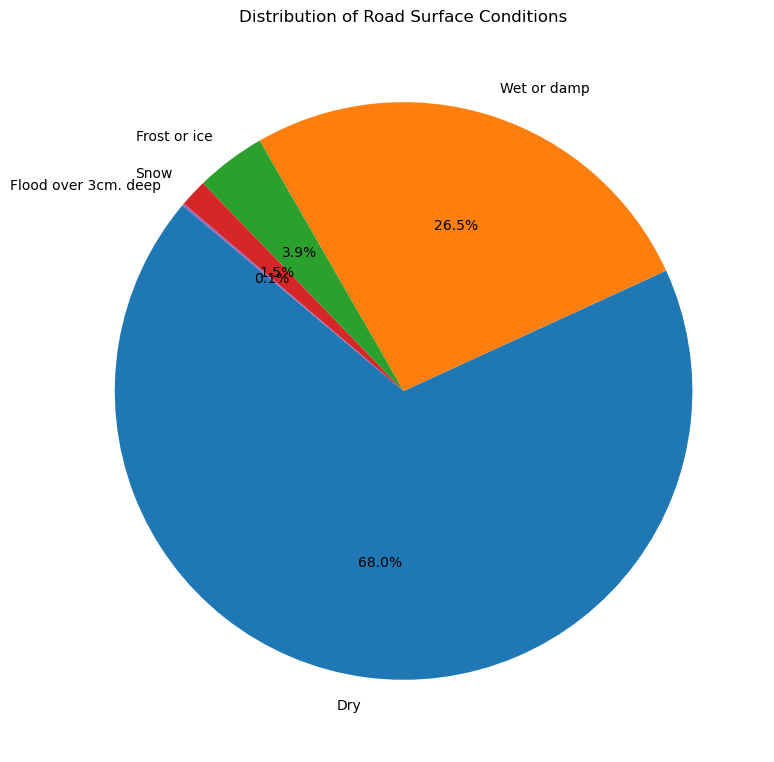

In [20]:
road_surface_counts = df['Road_Surface_Conditions'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(road_surface_counts, labels=road_surface_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Road Surface Conditions')
plt.tight_layout()
plt.show()


In [21]:
# Feature engineering
print("\nCreating new features...")
df['Hour'] = pd.to_datetime(df['Time']).dt.hour


Creating new features...


C:\Users\elsay\AppData\Local\Temp\ipykernel_5632\1657194457.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


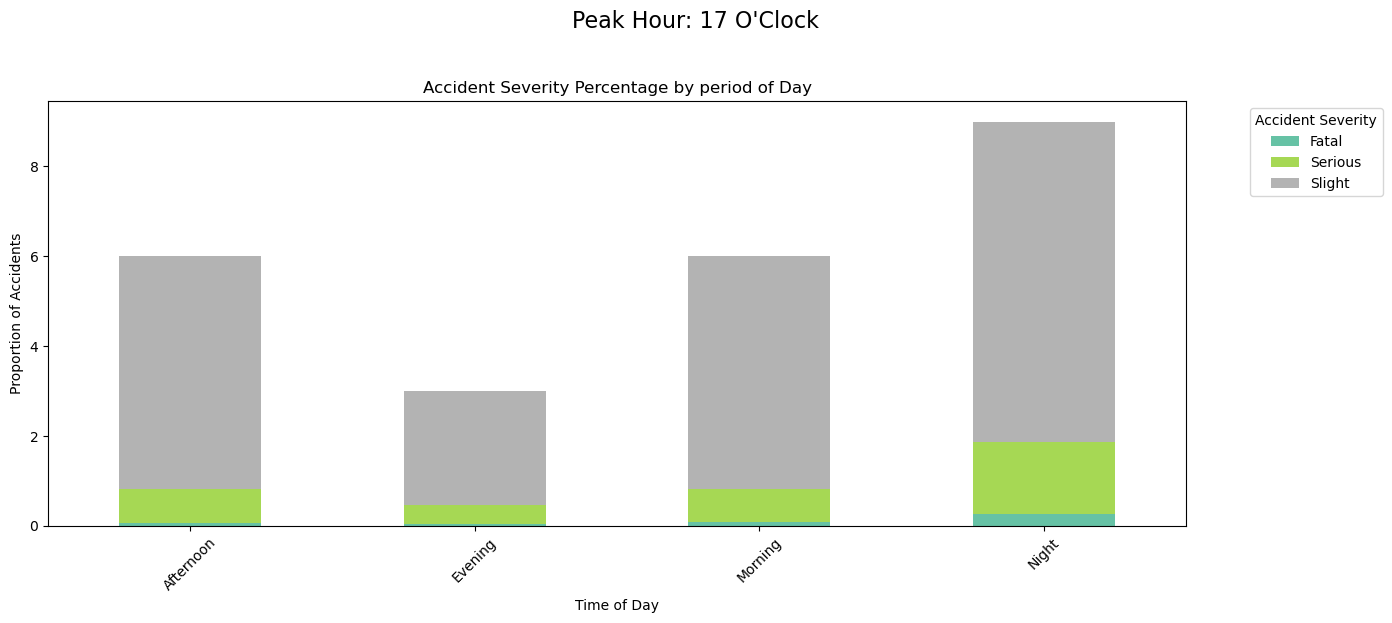

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Grouping accident severity by hour of the day
hourly_severity = df.groupby(['Hour', 'Accident_Severity']).size().unstack().fillna(0)
hourly_severity_pct = hourly_severity.div(hourly_severity.sum(axis=1), axis=0)

# Identify the peak hour (hour with the highest number of accidents)
peak_hour = hourly_severity.sum(axis=1).idxmax()

# Map hours to parts of the day
hour_to_period = {
    range(6, 12): 'Morning',
    range(12, 18): 'Afternoon',
    range(18, 21): 'Evening',
    range(21, 24): 'Night',
    range(0, 6): 'Night',
}

# Create a new column for time periods based on the 'Hour'
def get_time_period(hour):
    for time_range, period in hour_to_period.items():
        if hour in time_range:
            return period
    return 'Unknown'

hourly_severity_pct['Time_Period'] = hourly_severity_pct.index.get_level_values('Hour').map(get_time_period)

# Plot the data
fig, ax = plt.subplots(figsize=(14, 6))
hourly_severity_pct.groupby('Time_Period').sum().plot(kind='bar', stacked=True, colormap='Set2', ax=ax)

# Add title and labels
plt.title("Accident Severity Percentage by period of Day")
plt.xlabel("Time of Day")
plt.ylabel("Proportion of Accidents")
plt.xticks(rotation=45)
plt.legend(title="Accident Severity", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the peak hour in the plot title
plt.suptitle(f"Peak Hour: {peak_hour} O'Clock", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()


In [23]:
print("Columns in DataFrame:", df.columns.tolist())

Columns in DataFrame: ['Accident Date', 'Month', 'Day_of_Week', 'Year', 'Junction_Control', 'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions', 'Local_Authority_(District)', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type', 'Hour']


In [24]:
# Convert accident date to datetime
print("\nProcessing dates...")
df['Accident Date'] = pd.to_datetime(df['Accident Date'])


Processing dates...


In [25]:
# Time Series Analysis(accidents occurred each month & how accident severity changes over time (monthly))
print("\nPerforming time series analysis...")
monthly_accidents = df.resample('M', on='Accident Date').size()
severity_trends = df.groupby([pd.Grouper(key='Accident Date', freq='M'), 'Accident_Severity']).size().unstack()


Performing time series analysis...


C:\Users\elsay\AppData\Local\Temp\ipykernel_5632\1675307648.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_accidents = df.resample('M', on='Accident Date').size()
C:\Users\elsay\AppData\Local\Temp\ipykernel_5632\1675307648.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  severity_trends = df.groupby([pd.Grouper(key='Accident Date', freq='M'), 'Accident_Severity']).size().unstack()


# Determining which column to encode

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307968 entries, 0 to 307972
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Accident Date               307968 non-null  datetime64[ns]
 1   Month                       307968 non-null  object        
 2   Day_of_Week                 307968 non-null  object        
 3   Year                        307968 non-null  int64         
 4   Junction_Control            307968 non-null  object        
 5   Junction_Detail             307968 non-null  object        
 6   Accident_Severity           307968 non-null  object        
 7   Latitude                    307968 non-null  float64       
 8   Light_Conditions            307968 non-null  object        
 9   Local_Authority_(District)  307968 non-null  object        
 10  Longitude                   307968 non-null  float64       
 11  Number_of_Casualties        307968 non-null 

In [27]:
for col in ['Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail',
       'Accident_Severity', 'Light_Conditions',
       'Local_Authority_(District)',
        'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Time', 'Urban_or_Rural_Area',
       'Weather_Conditions', 'Vehicle_Type']:
    print(f"Unique values in {col}: {df[col].unique()}")
    print(f"number of unique values in {col}: {df[col].nunique()}")
    print("\n")

Unique values in Month: ['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Aug' 'Jul' 'Sep' 'Oct' 'Nov' 'Dec']
number of unique values in Month: 12


Unique values in Day_of_Week: ['Thursday' 'Monday' 'Sunday' 'Tuesday' 'Friday' 'Wednesday' 'Saturday']
number of unique values in Day_of_Week: 7


Unique values in Junction_Control: ['Give way or uncontrolled' 'Auto traffic signal'
 'Data missing or out of range' 'Authorised person' 'Stop sign'
 'Not at junction or within 20 metres']
number of unique values in Junction_Control: 6


Unique values in Junction_Detail: ['T or staggered junction' 'Crossroads'
 'Not at junction or within 20 metres' 'Roundabout' 'Mini-roundabout'
 'More than 4 arms (not roundabout)' 'Private drive or entrance'
 'Slip road' 'Other junction']
number of unique values in Junction_Detail: 9


Unique values in Accident_Severity: ['Serious' 'Slight' 'Fatal']
number of unique values in Accident_Severity: 3


Unique values in Light_Conditions: ['Daylight' 'Darkness - lights lit' 'Dar

# Encoding

In [28]:
# Prepare data for classification
print("\nPreparing data for classification models...")
LE = LabelEncoder()
categorical_cols = ['Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail',
                   'Light_Conditions', 'Local_Authority_(District)', 'Police_Force', 
                   'Road_Surface_Conditions', 'Road_Type', 'Urban_or_Rural_Area',
                   'Weather_Conditions', 'Vehicle_Type']

for col in categorical_cols:
    df[col] = LE.fit_transform(df[col])


Preparing data for classification models...


In [29]:
df.head()

,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,Local_Authority_(District),...,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type,Hour
0,2021-01-01,4,4,2021,3,8,Serious,51.512273,4,185,...,2,29,0,1,30,15:11,1,1,2,15
1,2021-01-05,4,1,2021,3,0,Serious,51.514399,4,185,...,2,29,4,3,30,10:59,1,1,13,10
2,2021-01-04,4,3,2021,3,8,Slight,51.486668,4,185,...,2,29,0,3,30,14:19,1,1,13,14
3,2021-01-05,4,1,2021,1,8,Serious,51.507804,4,185,...,2,29,2,3,30,8:10,1,3,9,8
4,2021-01-06,4,5,2021,1,0,Serious,51.482076,1,185,...,2,29,0,3,30,17:25,1,1,2,17


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307968 entries, 0 to 307972
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Accident Date               307968 non-null  datetime64[ns]
 1   Month                       307968 non-null  int32         
 2   Day_of_Week                 307968 non-null  int32         
 3   Year                        307968 non-null  int64         
 4   Junction_Control            307968 non-null  int32         
 5   Junction_Detail             307968 non-null  int32         
 6   Accident_Severity           307968 non-null  object        
 7   Latitude                    307968 non-null  float64       
 8   Light_Conditions            307968 non-null  int32         
 9   Local_Authority_(District)  307968 non-null  int32         
 10  Longitude                   307968 non-null  float64       
 11  Number_of_Casualties        307968 non-null 

In [31]:
# putting target in the end

In [32]:
Accident_Severity = df['Accident_Severity']
df.drop(['Accident_Severity'], axis=1, inplace=True)
df['Accident_Severity'] = Accident_Severity
df.head()

,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Longitude,...,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type,Hour,Accident_Severity
0,2021-01-01,4,4,2021,3,8,51.512273,4,185,-0.201349,...,29,0,1,30,15:11,1,1,2,15,Serious
1,2021-01-05,4,1,2021,3,0,51.514399,4,185,-0.199248,...,29,4,3,30,10:59,1,1,13,10,Serious
2,2021-01-04,4,3,2021,3,8,51.486668,4,185,-0.179599,...,29,0,3,30,14:19,1,1,13,14,Slight
3,2021-01-05,4,1,2021,1,8,51.507804,4,185,-0.203110,...,29,2,3,30,8:10,1,3,9,8,Serious
4,2021-01-06,4,5,2021,1,0,51.482076,1,185,-0.173445,...,29,0,3,30,17:25,1,1,2,17,Serious


# spliting

In [33]:
# Split data
X = df.drop(['Accident_Severity', 'Accident Date'], axis=1)
y = df['Accident_Severity']

In [34]:
X.shape, y.shape

((307968, 20), (307968,))

In [35]:
X.head()

,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Longitude,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type,Hour
0,4,4,2021,3,8,51.512273,4,185,-0.201349,1,2,29,0,1,30,15:11,1,1,2,15
1,4,1,2021,3,0,51.514399,4,185,-0.199248,11,2,29,4,3,30,10:59,1,1,13,10
2,4,3,2021,3,8,51.486668,4,185,-0.179599,1,2,29,0,3,30,14:19,1,1,13,14
3,4,1,2021,1,8,51.507804,4,185,-0.203110,1,2,29,2,3,30,8:10,1,3,9,8
4,4,5,2021,1,0,51.482076,1,185,-0.173445,1,2,29,0,3,30,17:25,1,1,2,17


In [36]:
y.head()

0    Serious
1    Serious
2     Slight
3    Serious
4    Serious
Name: Accident_Severity, dtype: object

# Outlier

In [37]:
def outliers(df, column):
    Q1 = df[column].quantile(0.25)      
    Q3 = df[column].quantile(0.75)       
    IQR = Q3 - Q1                        
    outlier_indices = df[
        (df[column] < (Q1 - 1.5 * IQR)) | 
        (df[column] > (Q3 + 1.5 * IQR))
    ].index                              
    return outlier_indices

In [38]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numeric columns:", numeric_cols)

Numeric columns: ['Year', 'Latitude', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit']


In [39]:
def outliers(df, column):
    if df[column].dtype in ['int64', 'float64']:  # Only for numeric columns
        Q1 = df[column].quantile(0.25)      
        Q3 = df[column].quantile(0.75)       
        IQR = Q3 - Q1                        
        outlier_indices = df[
            (df[column] < (Q1 - 1.5 * IQR)) | 
            (df[column] > (Q3 + 1.5 * IQR))
        ].index                              
        return outlier_indices
    return pd.Index([])  # Return empty index for non-numeric columns

# Now run only on numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    outlier_idx = outliers(df, col)
    print(f"{col} => outlier_idx : {len(outlier_idx)}")


Year => outlier_idx : 0
Latitude => outlier_idx : 3334
Longitude => outlier_idx : 655
Number_of_Casualties => outlier_idx : 72879
Number_of_Vehicles => outlier_idx : 6803
Speed_limit => outlier_idx : 0


C:\Users\elsay\AppData\Local\Temp\ipykernel_5632\1016949405.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_df, x='Feature', y='Outlier Count', palette='Reds_r')


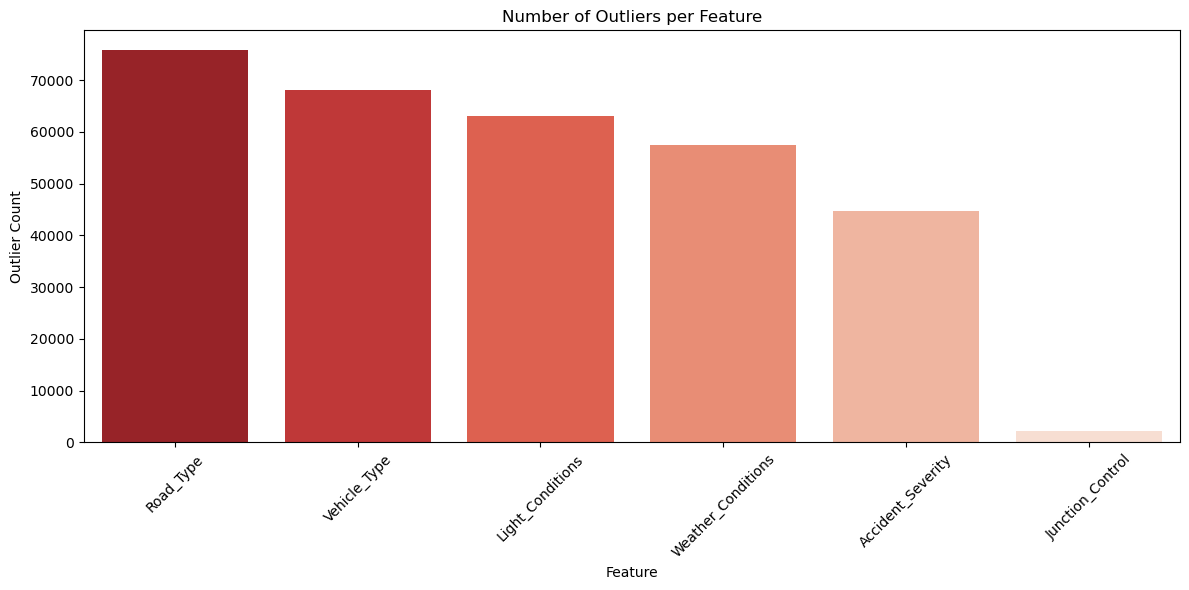

In [40]:
outlier_counts = {
    'Junction_Control': 2145,
    'Accident_Severity': 44693,
    'Light_Conditions': 63017,
    'Road_Type': 75826,
    'Weather_Conditions': 57419,
    'Vehicle_Type': 68179
}

outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier Count'])
outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=outlier_df, x='Feature', y='Outlier Count', palette='Reds_r')
plt.title('Number of Outliers per Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


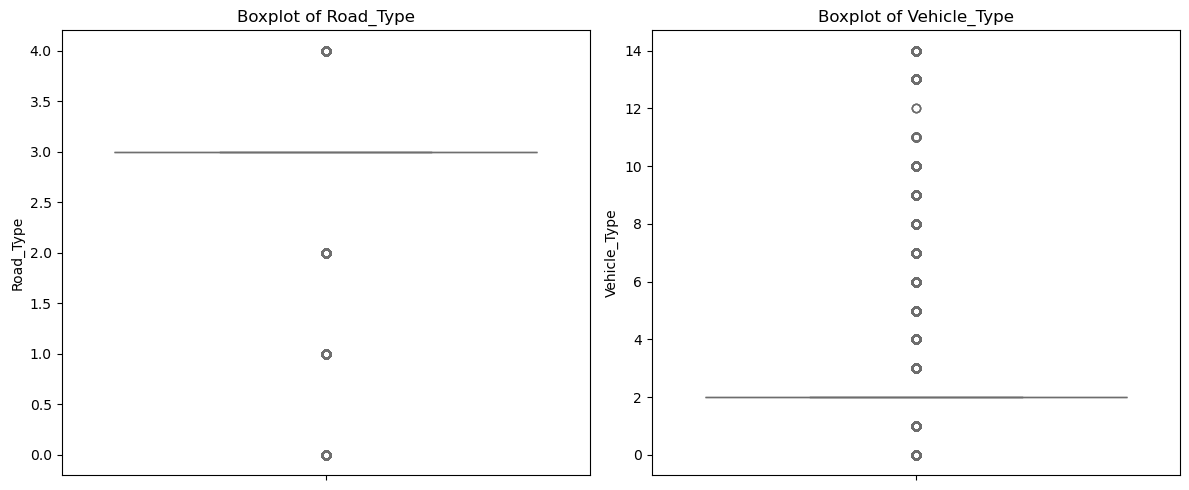

In [41]:

df_numeric = df.copy()
df_numeric['Vehicle_Type'] = df_numeric['Vehicle_Type'].astype('category').cat.codes
df_numeric['Road_Type'] = df_numeric['Road_Type'].astype('category').cat.codes
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(y=df_numeric['Road_Type'], color='skyblue')
plt.title('Boxplot of Road_Type')
plt.subplot(1,2,2)
sns.boxplot(y=df_numeric['Vehicle_Type'], color='salmon')
plt.title('Boxplot of Vehicle_Type')
plt.tight_layout()
plt.show()


In [42]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [43]:
def remove_outliers(df, column):
    """Remove outliers from a column, handling both numeric and categorical data"""
    if df[column].dtype in ['int64', 'float64']:
        # For numeric columns: use IQR method
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    else:
        # For categorical columns: remove rare categories (appearing less than 1% of time)
        value_counts = df[column].value_counts(normalize=True)
        common_categories = value_counts[value_counts >= 0.01].index
        return df[df[column].isin(common_categories)]

# Columns to process (including both numeric and categorical)
cols_with_outliers = ['Junction_Control', 'Accident_Severity',
                     'Light_Conditions', 'Road_Type', 'Weather_Conditions', 
                     'Vehicle_Type', 'Road_Surface_Conditions']

# Remove outliers from each column
for col in cols_with_outliers:
    print(f"\nProcessing column: {col}")
    print(f"Original shape: {df.shape}")
    df = remove_outliers(df, col)
    print(f"New shape: {df.shape}")


Processing column: Junction_Control
Original shape: (307968, 22)
New shape: (305823, 22)

Processing column: Accident_Severity
Original shape: (305823, 22)
New shape: (305823, 22)

Processing column: Light_Conditions
Original shape: (305823, 22)
New shape: (301791, 22)

Processing column: Road_Type
Original shape: (301791, 22)
New shape: (301791, 22)

Processing column: Weather_Conditions
Original shape: (301791, 22)
New shape: (299655, 22)

Processing column: Vehicle_Type
Original shape: (299655, 22)
New shape: (293171, 22)

Processing column: Road_Surface_Conditions
Original shape: (293171, 22)
New shape: (292812, 22)


In [44]:
numeric_cols = ['Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail',
       'Accident_Severity', 'Light_Conditions',
       'Local_Authority_(District)',
        'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Time', 'Urban_or_Rural_Area',
       'Weather_Conditions', 'Vehicle_Type']
for col in numeric_cols:
    outlier_idx = outliers(df, col)
    print(f"{col} => outlier_idx : {len(outlier_idx)}")

Month => outlier_idx : 0
Day_of_Week => outlier_idx : 0
Junction_Control => outlier_idx : 0
Junction_Detail => outlier_idx : 0
Accident_Severity => outlier_idx : 0
Light_Conditions => outlier_idx : 0
Local_Authority_(District) => outlier_idx : 0
Police_Force => outlier_idx : 0
Road_Surface_Conditions => outlier_idx : 0
Road_Type => outlier_idx : 0
Time => outlier_idx : 0
Urban_or_Rural_Area => outlier_idx : 0
Weather_Conditions => outlier_idx : 0
Vehicle_Type => outlier_idx : 0


# Making Data balanced

# Scaling

In [45]:
# 1. First ensure all features are numeric
print("Checking data types before normalization:")
print(X.dtypes)  # If X is numpy array, check df.dtypes before splitting

# 2. Convert time strings to numerical features (if present)
if 'Time' in df.columns:
    df['Hour'] = pd.to_datetime(df['Time']).dt.hour
    df['Minute'] = pd.to_datetime(df['Time']).dt.minute
    df.drop('Time', axis=1, inplace=True)

# 3. Ensure all categorical columns are label encoded
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print("\nLabel encoding categorical columns:", list(categorical_cols))
    le = LabelEncoder()
    for col in categorical_cols:
        X[col] = le.fit_transform(X[col])

# 4. Now normalize
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

Checking data types before normalization:
Month                           int32
Day_of_Week                     int32
Year                            int64
Junction_Control                int32
Junction_Detail                 int32
Latitude                      float64
Light_Conditions                int32
Local_Authority_(District)      int32
Longitude                     float64
Number_of_Casualties            int64
Number_of_Vehicles              int64
Police_Force                    int32
Road_Surface_Conditions         int32
Road_Type                       int32
Speed_limit                     int64
Time                           object
Urban_or_Rural_Area             int32
Weather_Conditions              int32
Vehicle_Type                    int32
Hour                            int32
dtype: object


C:\Users\elsay\AppData\Local\Temp\ipykernel_5632\3876704077.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour
C:\Users\elsay\AppData\Local\Temp\ipykernel_5632\3876704077.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Minute'] = pd.to_datetime(df['Time']).dt.minute



Label encoding categorical columns: ['Time']


# imbalance Data cause overfitting


<Axes: title={'center': 'Accident_Severity'}, xlabel='Accident_Severity'>

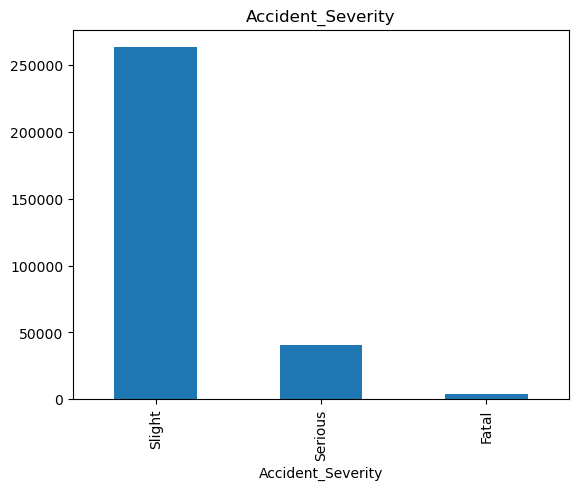

In [46]:
y.value_counts().plot.bar(title="Accident_Severity")

In [47]:
print("Accident_Severity        : \n",y.value_counts())
print("\n")
print(y.value_counts(normalize=True))

Accident_Severity        : 
 Accident_Severity
Slight     263275
Serious     40740
Fatal        3953
Name: count, dtype: int64


Accident_Severity
Slight     0.854878
Serious    0.132286
Fatal      0.012836
Name: proportion, dtype: float64


# Data balancing

In [48]:
# Handle class imbalance
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

In [49]:
X.shape

(789825, 20)

In [50]:
y.shape

(789825,)

In [51]:
print("Accident_Severity        : \n",y.value_counts())
print("\n")
print(y.value_counts(normalize=True))

Accident_Severity        : 
 Accident_Severity
Serious    263275
Slight     263275
Fatal      263275
Name: count, dtype: int64


Accident_Severity
Serious    0.333333
Slight     0.333333
Fatal      0.333333
Name: proportion, dtype: float64


<Axes: title={'center': 'Accident_Severity'}, xlabel='Accident_Severity'>

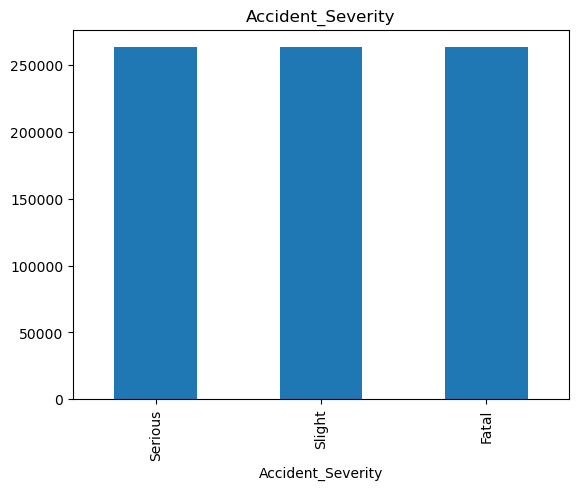

In [52]:
y.value_counts().plot.bar(title="Accident_Severity")

# Data Modeling

In [53]:
X_train, X_test, y_train, y_test =train_test_split(X,y, test_size= 0.20, random_state=100, stratify=y)

In [54]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)   
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (631860, 20)
X_test shape:  (157965, 20)
y_train shape:  (631860,)
y_test shape:  (157965,)


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

Models = {
    'LogisticRegression': LogisticRegression(),
    'GaussianNB': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(),
}

In [61]:
ModelName = []
ModelAccuracy = []

for nameModel, model in tqdm(Models.items()):
    model.fit(X_train, y_train)
    ModelName.append(nameModel)
    y_pred = model.predict(X_test)
    ModelAccuracy.append([
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='weighted'), # weighted because of multi classification
        recall_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, y_pred, average='weighted')
    ])

Model_accuracy = pd.DataFrame(ModelAccuracy, index=ModelName, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
Model_accuracy

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\elsay\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 3/3 [19:08<00:00, 382.93s/it]


,Accuracy,Precision,Recall,F1 Score
LogisticRegression,0.472269,0.465150,0.472269,0.464286
GaussianNB,0.467160,0.466085,0.467160,0.466273
RandomForestClassifier,0.941139,0.945837,0.941139,0.940885


In [62]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Confusion Matrix: 
 [[51916   195   544]
 [  607 44913  7135]
 [   50   767 51838]]


In [74]:
best_model_name = Model_accuracy['F1 Score'].idxmax()
best_model = Models[best_model_name]

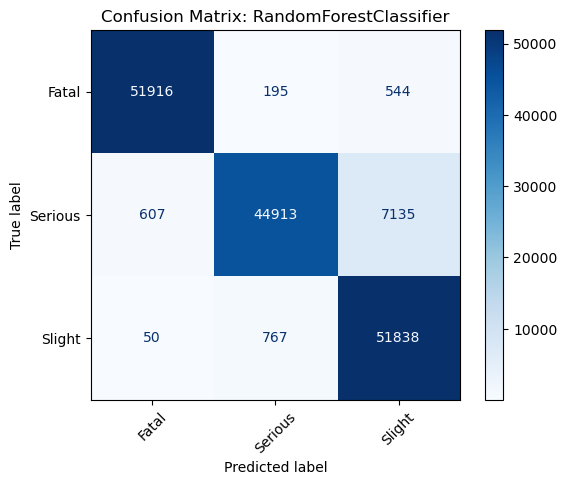

In [70]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(f'Confusion Matrix: {best_model_name}')
plt.show()

In [72]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
results_df.head(20)  # عرض أول 20 صف

,Actual,Predicted
95105,Slight,Slight
421522,Fatal,Fatal
603511,Serious,Serious
476529,Fatal,Fatal
556027,Fatal,Serious
739553,Serious,Serious
247354,Slight,Slight
66855,Slight,Slight
765928,Serious,Serious
763623,Serious,Serious


In [73]:
from sklearn.metrics import classification_report

print(f"Classification Report for {best_model_name}:\n")
print(classification_report(y_test, y_pred))


Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

       Fatal       0.99      0.99      0.99     52655
     Serious       0.98      0.85      0.91     52655
      Slight       0.87      0.98      0.92     52655

    accuracy                           0.94    157965
   macro avg       0.95      0.94      0.94    157965
weighted avg       0.95      0.94      0.94    157965



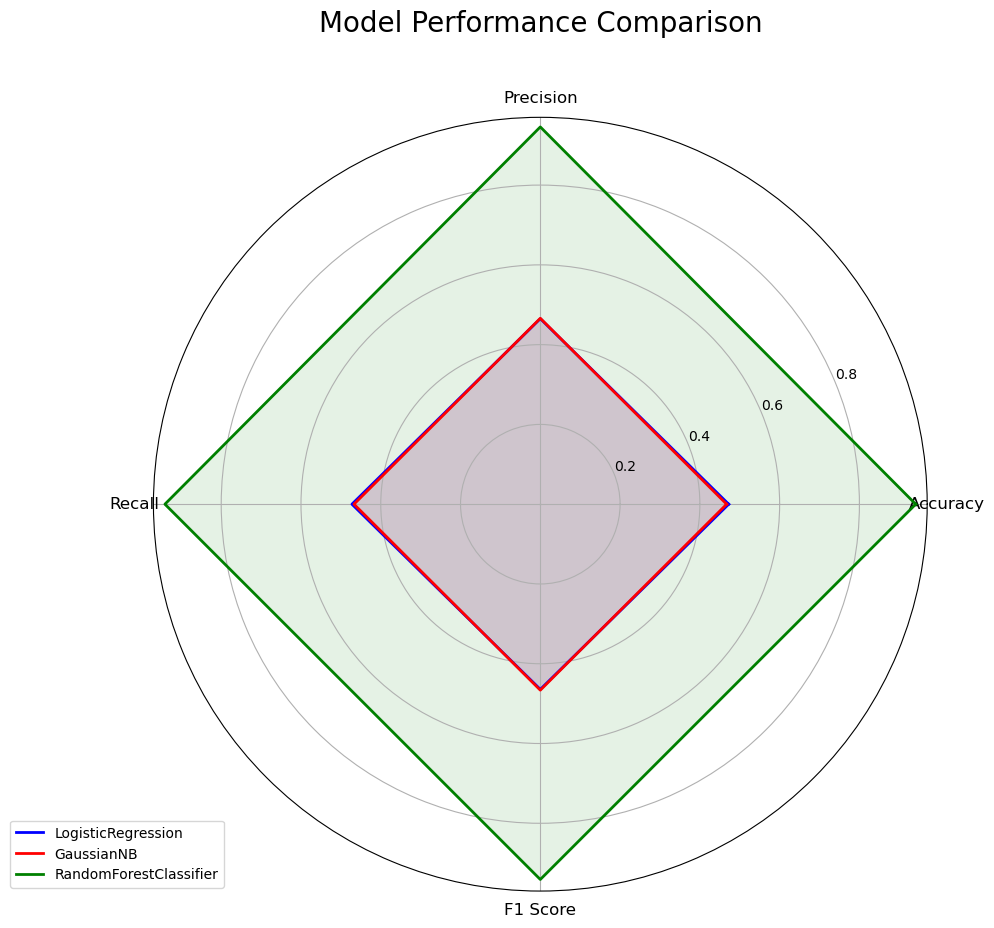

In [64]:
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_chart(df, title):
    # عدد المتغيرات
    categories = list(df.columns)
    N = len(categories)
    
    # نحدث قيم كل نموذج
    models = list(df.index)
    
    # زاوية كل محور
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # إغلاق الشكل
    
    # إنشاء المخطط
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # رسم محور لكل متغير
    plt.xticks(angles[:-1], categories, size=12)
    
    # رسم بيانات كل نموذج
    colors = ['b', 'r', 'g', 'y', 'c', 'm']
    for i, model_name in enumerate(models):
        values = df.loc[model_name].values.tolist()
        values += values[:1]  # إغلاق الشكل
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name, color=colors[i % len(colors)])
        ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(title, size=20, y=1.1)
    plt.tight_layout()
    plt.show()

# استخدام الدالة لرسم أداء النماذج
radar_chart(Model_accuracy, 'Model Performance Comparison')

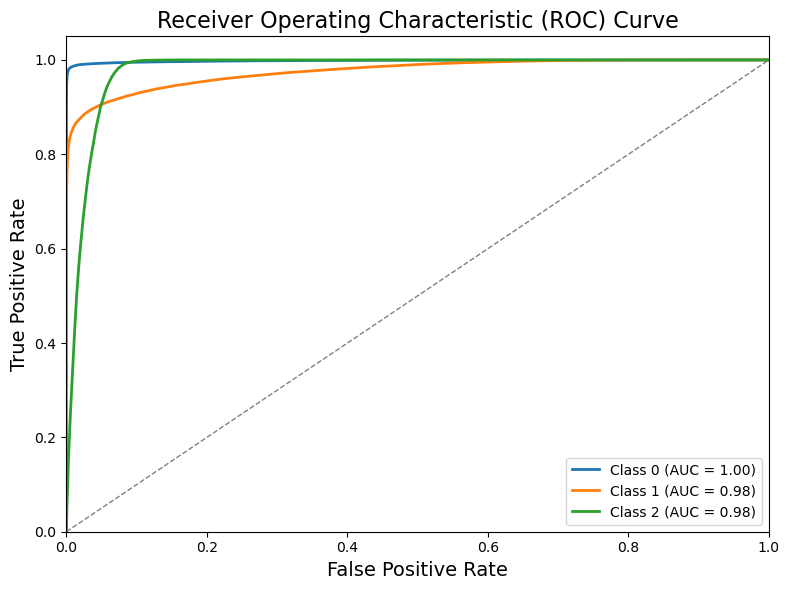

In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Only for binary classification or one-vs-rest
plt.figure(figsize=(8, 6))

# Convert multi-class to one-vs-rest if needed
if len(np.unique(y_test)) > 2:
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_proba = model.predict_proba(X_test)
    
    for i in range(len(np.unique(y_test))):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
else:
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    except:
        print("Model doesn't support predict_proba method")

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

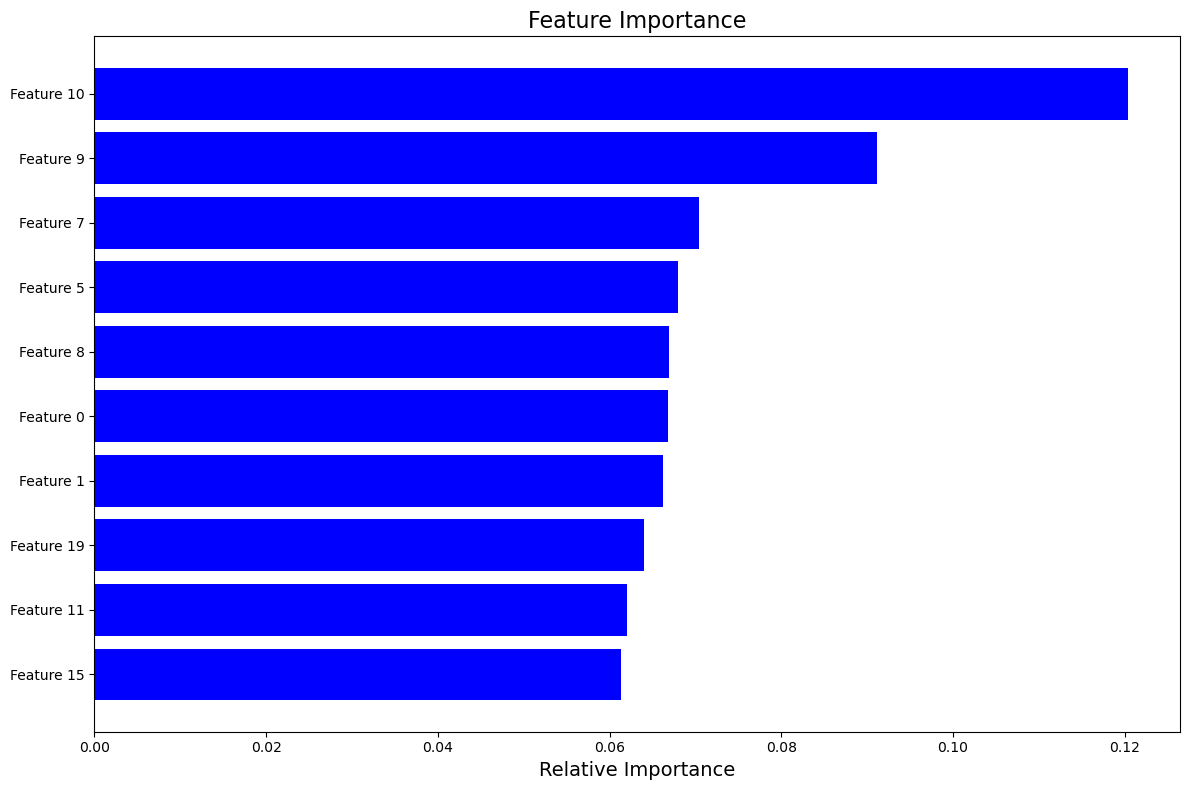

In [66]:
# للنموذج RandomForest
if 'RandomForestClassifier' in str(type(model)):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]  # عرض أهم 10 متغيرات
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance', fontsize=16)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    
    # إذا كان X_train مصفوفة، استخدم أرقام كعناوين للمتغيرات
    try:
        feature_names = X.columns[indices]
    except:
        feature_names = [f"Feature {i}" for i in indices]
    
    plt.yticks(range(len(indices)), feature_names)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.tight_layout()
    plt.show()

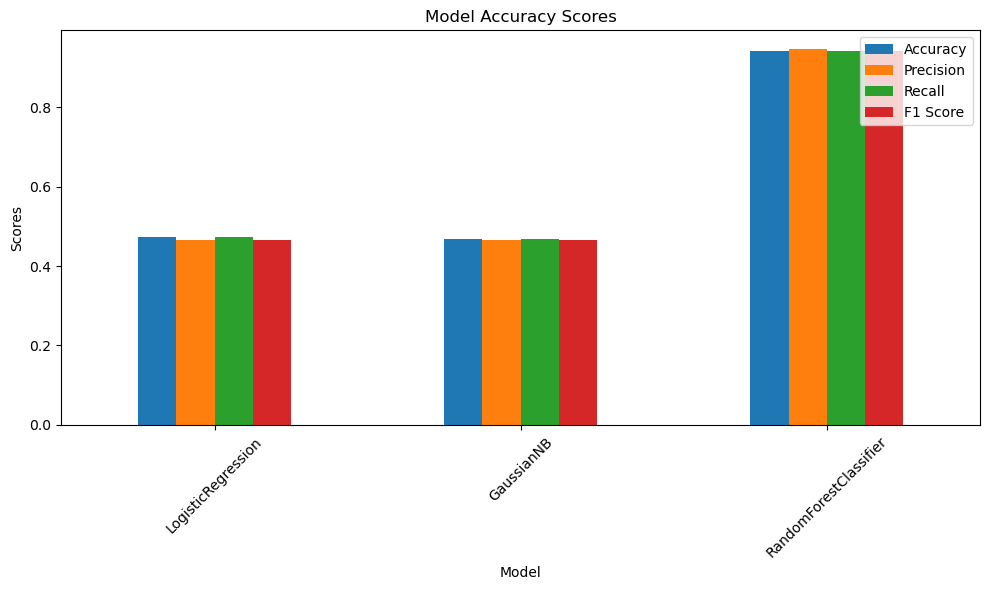

In [67]:
Model_accuracy.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Accuracy Scores')
plt.xticks(rotation=45)  
plt.legend(loc='upper right')
plt.tight_layout() 
plt.show()